# Probablistic linear models using Pyro
August George, 2024, PNNL

## Linear regression

$y_i = m_i*x_i + b_i$

In [1]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoNormal


pyro.set_rng_seed(42)

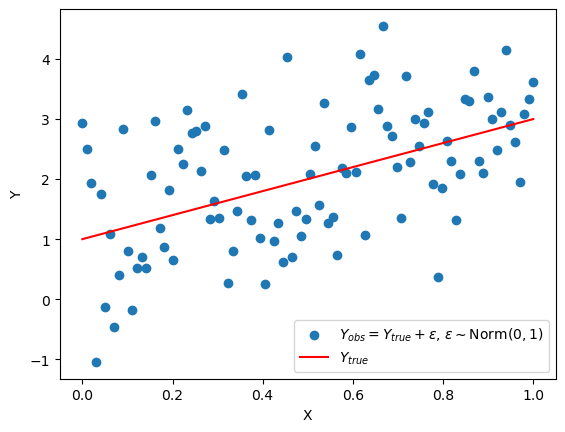

In [2]:
# simulate the data
true_intercept = 1
true_slope = 2
num_data_points = 100  
X_values = torch.linspace(0, 1, num_data_points)
Y_values = true_intercept + true_slope * X_values 
Y_obs_values = Y_values + torch.randn(num_data_points) 


plt.scatter(X_values, Y_obs_values, label=r'$Y_{obs} = Y_{true} + \epsilon$, $\epsilon \sim \text{Norm}(0,1)$')
plt.plot(X_values, Y_values, color='red', label=r'$Y_{true}$')
plt.ylabel('Y')
plt.xlabel('X')
plt.legend()
plt.show()

## Bayesian inference using NUTS

In [3]:
def linear_model(X_values, Y_values):
    intercept_prior = pyro.sample('intercept', dist.Normal(0, 10))
    slope_prior = pyro.sample('slope', dist.Normal(0, 10))
    noise_std_prior = pyro.sample('noise_std', dist.LogNormal(0, 1)) 
    mean_prediction = intercept_prior + slope_prior * X_values
    with pyro.plate('data', len(X_values)):
        pyro.sample('observations', dist.Normal(mean_prediction, noise_std_prior), obs=Y_values)

# MCMC inference
nuts_kernel = NUTS(linear_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(X_values, Y_obs_values)
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 1200/1200 [00:05, 212.27it/s, step size=3.91e-01, acc. prob=0.912]


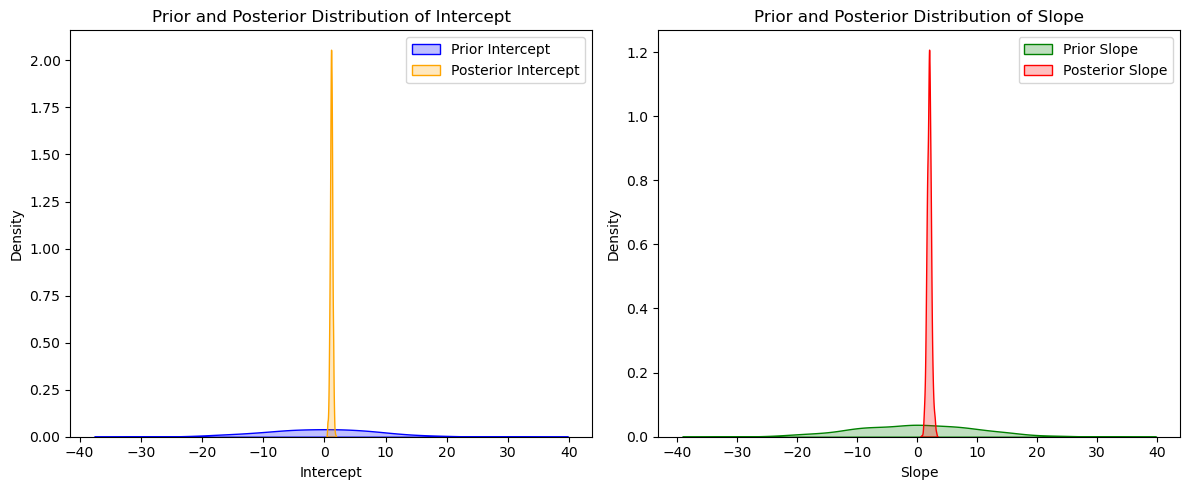

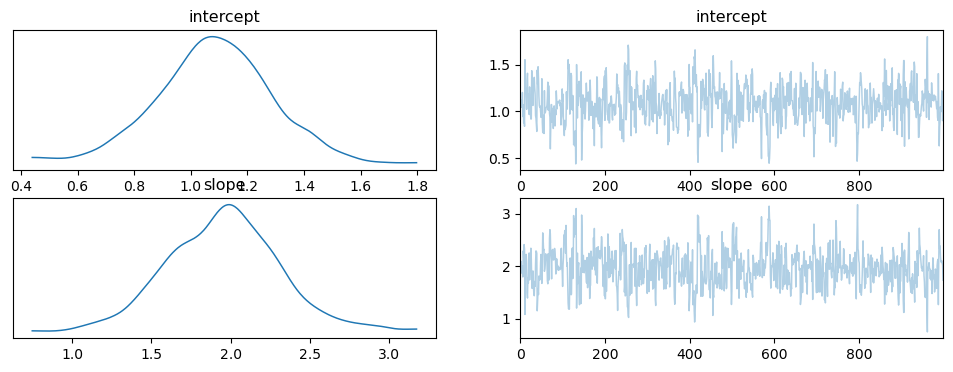

'MCMC intercept_mean = 1.0818113088607788, intercept_std = 0.20343944430351257'

'MCMC SVI slope_mean = 1.9572992324829102, slope_std = 0.35353732109069824'

In [4]:
intercept_samples = posterior_samples["intercept"]
slope_samples = posterior_samples["slope"]
noise_std_samples = posterior_samples["noise_std"]
prior_intercept_samples = dist.Normal(0, 10).sample([1000])
prior_slope_samples = dist.Normal(0, 10).sample([1000])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.kdeplot(prior_intercept_samples.numpy(), fill=True, color='blue', label='Prior Intercept', ax=axs[0])
sns.kdeplot(intercept_samples.numpy(), fill=True, color='orange', label='Posterior Intercept', ax=axs[0])
axs[0].set_title('Prior and Posterior Distribution of Intercept')
axs[0].set_xlabel('Intercept')
axs[0].set_ylabel('Density')
axs[0].legend()
sns.kdeplot(prior_slope_samples.numpy(), fill=True, color='green', label='Prior Slope', ax=axs[1])
sns.kdeplot(slope_samples.numpy(), fill=True, color='red', label='Posterior Slope', ax=axs[1])
axs[1].set_title('Prior and Posterior Distribution of Slope')
axs[1].set_xlabel('Slope')
axs[1].set_ylabel('Density')
axs[1].legend()
plt.tight_layout()
plt.show()

az.plot_trace({"intercept": intercept_samples, "slope": slope_samples})
plt.show()

intercept_mean = intercept_samples.mean().item()
intercept_std = intercept_samples.std().item()
slope_mean = slope_samples.mean().item()
slope_std = slope_samples.std().item()
noise_std_mean = noise_std_samples.mean().item()
noise_std_std = noise_std_samples.std().item()

display(f"MCMC intercept_mean = {intercept_mean}, intercept_std = {intercept_std}")
display(f"MCMC SVI slope_mean = {slope_mean}, slope_std = {slope_std}")

## Variational inference

Manual SVI Step 0 : loss = 722.7371839880943
Manual SVI Step 100 : loss = 226.2641046643257
Manual SVI Step 200 : loss = 214.20566296577454
Manual SVI Step 300 : loss = 242.68440502882004
Manual SVI Step 400 : loss = 184.43960613012314
Manual SVI Step 500 : loss = 311.70145773887634
Manual SVI Step 600 : loss = 205.08398658037186
Manual SVI Step 700 : loss = 139.01043218374252
Manual SVI Step 800 : loss = 345.2174941897392
Manual SVI Step 900 : loss = 223.11412766575813


/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_60062/3685320967.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise_std_loc = torch.tensor(pyro.param('noise_std_loc'))  # Convert to tensor
/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_60062/3685320967.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise_std_scale = torch.tensor(pyro.param('noise_std_scale'))


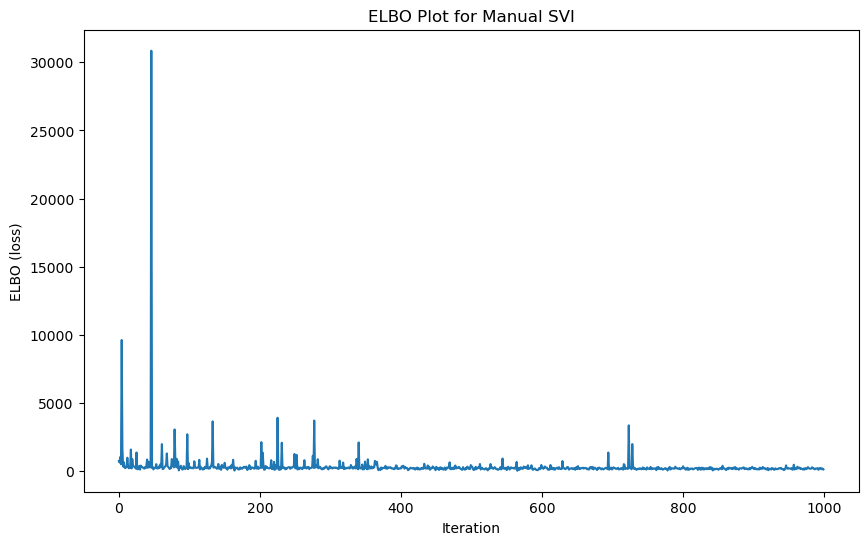

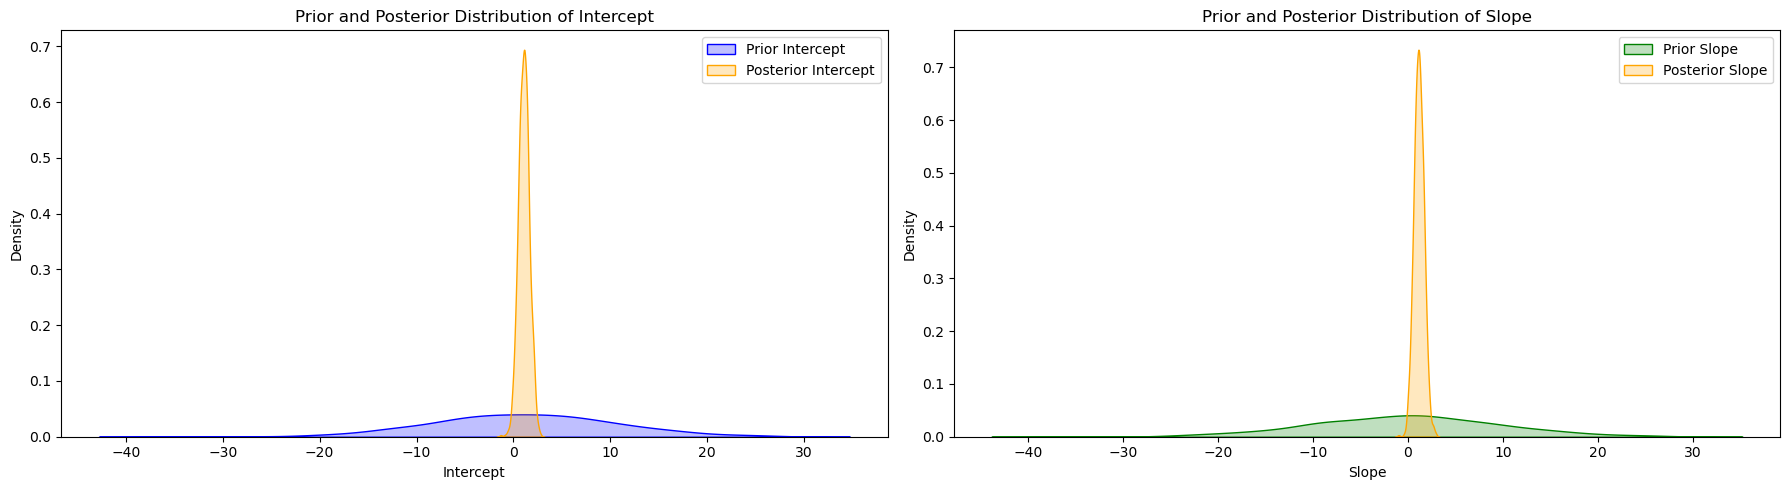

'Manual SVI intercept_mean = 1.0760087966918945, intercept_std = 0.5546518564224243'

'Manual SVI slope_mean = 1.1469656229019165, slope_std = 0.5253327488899231'

In [5]:
def linear_model_guide(X_values, Y_values):
    intercept_loc = pyro.param('intercept_loc', torch.tensor(0.0))
    intercept_scale = pyro.param('intercept_scale', torch.tensor(1.0), constraint=torch.distributions.constraints.positive)
    slope_loc = pyro.param('slope_loc', torch.tensor(0.0))
    slope_scale = pyro.param('slope_scale', torch.tensor(1.0), constraint=torch.distributions.constraints.positive)
    noise_std_loc = pyro.param('noise_std_loc', torch.tensor(0.0))
    noise_std_scale = pyro.param('noise_std_scale', torch.tensor(1.0), constraint=torch.distributions.constraints.positive)
    pyro.sample('intercept', dist.Normal(intercept_loc, intercept_scale))
    pyro.sample('slope', dist.Normal(slope_loc, slope_scale))
    pyro.sample('noise_std', dist.LogNormal(noise_std_loc, noise_std_scale))


optimizer = optim.Adam({"lr": 0.01})
svi_manual = SVI(linear_model, linear_model_guide, optimizer, loss=Trace_ELBO())
num_iterations = 1000
elbo_values = []  
for step in range(num_iterations):
    loss = svi_manual.step(X_values, Y_values)
    elbo_values.append(loss)
    if step % 100 == 0:
        print(f"Manual SVI Step {step} : loss = {loss}")

intercept_loc = pyro.param('intercept_loc').item()
intercept_scale = pyro.param('intercept_scale').item()
slope_loc = pyro.param('slope_loc').item()
slope_scale = pyro.param('slope_scale').item()
noise_std_loc = torch.tensor(pyro.param('noise_std_loc'))  # Convert to tensor
noise_std_scale = torch.tensor(pyro.param('noise_std_scale'))  
noise_std_exp = torch.exp(noise_std_loc).item()

prior_intercept_samples = dist.Normal(0, 10).sample([1000]).numpy()
prior_slope_samples = dist.Normal(0, 10).sample([1000]).numpy()
intercept_samples = dist.Normal(intercept_loc, intercept_scale).sample([1000]).numpy()
slope_samples = dist.Normal(slope_loc, slope_scale).sample([1000]).numpy()

plt.figure(figsize=(10, 6))
plt.plot(elbo_values)
plt.xlabel('Iteration')
plt.ylabel('ELBO (loss)')
plt.title('ELBO Plot for Manual SVI')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(18, 5))
sns.kdeplot(prior_intercept_samples, fill=True, color='blue', label='Prior Intercept', ax=axs[0])
sns.kdeplot(intercept_samples, fill=True, color='orange', label='Posterior Intercept', ax=axs[0])
axs[0].set_title('Prior and Posterior Distribution of Intercept')
axs[0].set_xlabel('Intercept')
axs[0].set_ylabel('Density')
axs[0].legend()

sns.kdeplot(prior_slope_samples, fill=True, color='green', label='Prior Slope', ax=axs[1])
sns.kdeplot(slope_samples, fill=True, color='orange', label='Posterior Slope', ax=axs[1])
axs[1].set_title('Prior and Posterior Distribution of Slope')
axs[1].set_xlabel('Slope')
axs[1].set_ylabel('Density')
axs[1].legend()
plt.tight_layout()
plt.show()


display(f"Manual SVI intercept_mean = {intercept_loc}, intercept_std = {intercept_scale}")
display(f"Manual SVI slope_mean = {slope_loc}, slope_std = {slope_scale}")

## Variational inference using an autoguide

Step 0 : loss = 378.62572295591235
Step 100 : loss = 165.636390209198
Step 200 : loss = 72.33421650528908
Step 300 : loss = -6.356635928153992
Step 400 : loss = -92.04667925834656
Step 500 : loss = -170.9732781648636
Step 600 : loss = -238.78315842151642
Step 700 : loss = -229.9948843717575
Step 800 : loss = -292.01425564289093
Step 900 : loss = -353.3954985141754


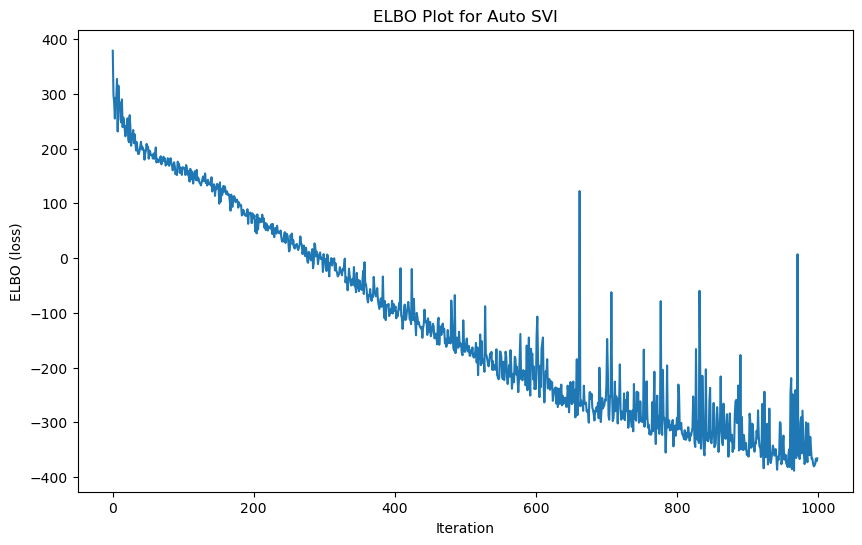

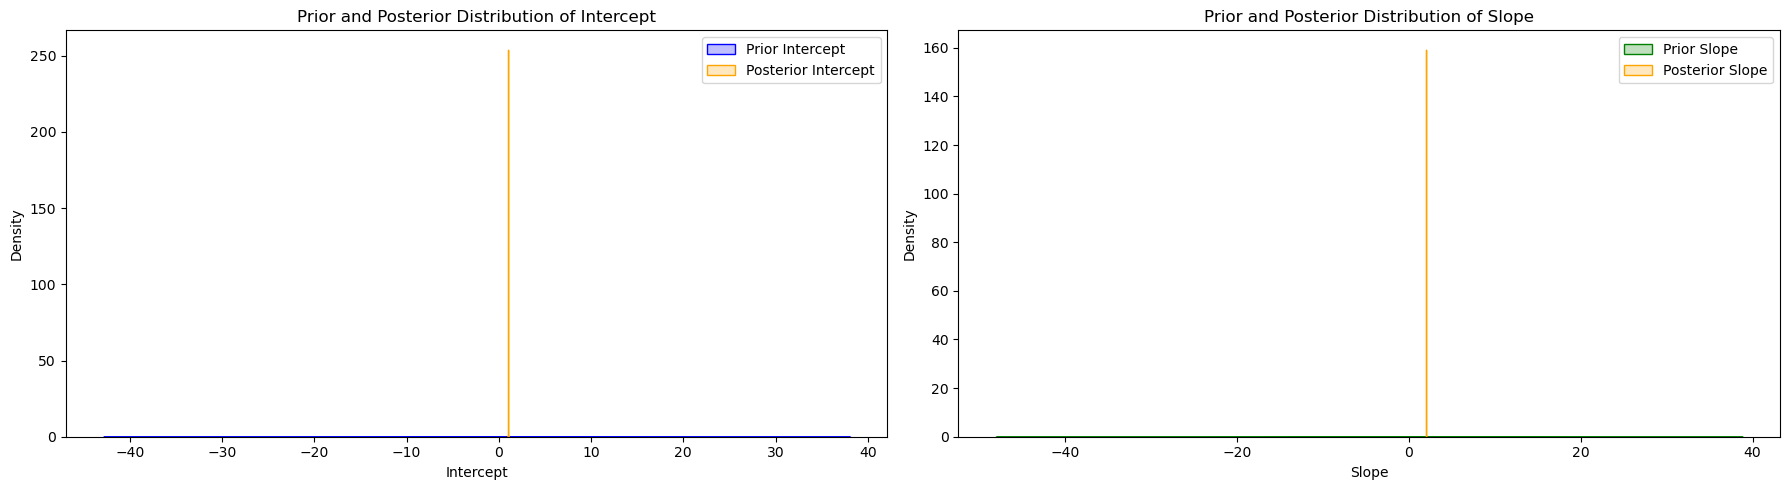

'Auto SVI intercept_mean = 1.000591516494751, intercept_std = 0.0016187389846891165'

'Auto SVI slope_mean = 1.9996989965438843, slope_std = 0.0025099560152739286'

'Auto SVI noise_std_mean = 1.006721019744873, noise_std_std = 0.0007572152535431087'

In [6]:
auto_guide = AutoNormal(linear_model)
optimizer = optim.Adam({"lr": 0.01})
svi = SVI(linear_model, auto_guide, optimizer, loss=Trace_ELBO())

num_iterations = 1000
elbo_values = []  
for step in range(num_iterations):
    loss = svi.step(X_values, Y_values)
    elbo_values.append(loss)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

# get samples
prior_intercept_samples = dist.Normal(0, 10).sample([1000]).numpy()
prior_slope_samples = dist.Normal(0, 10).sample([1000]).numpy()
posterior_samples = [auto_guide() for _ in range(1000)]
posterior_samples = {k: torch.stack([s[k] for s in posterior_samples]) for k in posterior_samples[0]}
intercept_samples = posterior_samples['intercept'].detach().numpy()
slope_samples = posterior_samples['slope'].detach().numpy()
noise_std_samples = torch.exp(posterior_samples['noise_std']).detach().numpy()
intercept_mean = intercept_samples.mean()
intercept_std = intercept_samples.std()
slope_mean = slope_samples.mean()
slope_std = slope_samples.std()
noise_std_mean = noise_std_samples.mean()
noise_std_std = noise_std_samples.std()

# plot
plt.figure(figsize=(10, 6))
plt.plot(elbo_values)
plt.xlabel('Iteration')
plt.ylabel('ELBO (loss)')
plt.title('ELBO Plot for Auto SVI')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(18, 5))
sns.kdeplot(prior_intercept_samples, fill=True, color='blue', label='Prior Intercept', ax=axs[0])
sns.kdeplot(intercept_samples, fill=True, color='orange', label='Posterior Intercept', ax=axs[0])
axs[0].set_title('Prior and Posterior Distribution of Intercept')
axs[0].set_xlabel('Intercept')
axs[0].set_ylabel('Density')
axs[0].legend()

sns.kdeplot(prior_slope_samples, fill=True, color='green', label='Prior Slope', ax=axs[1])
sns.kdeplot(slope_samples, fill=True, color='orange', label='Posterior Slope', ax=axs[1])
axs[1].set_title('Prior and Posterior Distribution of Slope')
axs[1].set_xlabel('Slope')
axs[1].set_ylabel('Density')
axs[1].legend()

plt.tight_layout()
plt.show()

display(f"Auto SVI intercept_mean = {intercept_mean}, intercept_std = {intercept_std}")
display(f"Auto SVI slope_mean = {slope_mean}, slope_std = {slope_std}")
display(f"Auto SVI noise_std_mean = {noise_std_mean}, noise_std_std = {noise_std_std}")


## linear structural causal model from gene regulatory network

A --> B

B --> C

D --| B

In [7]:
# Number of samples
num_samples = 100

# Ground truth parameters
true_beta_A_B = 2.0
true_beta_D_B = -1.0
true_beta_B_C = 1.5

# Generate synthetic data
epsilon_A = torch.normal(0, 1, (num_samples,))
epsilon_B = torch.normal(0, 1, (num_samples,))
epsilon_C = torch.normal(0, 1, (num_samples,))
epsilon_D = torch.normal(0, 1, (num_samples,))

A = epsilon_A
D = epsilon_D
B = true_beta_A_B * A + true_beta_D_B * D + epsilon_B
C = true_beta_B_C * B + epsilon_C


# Print first few samples for inspection
display('Synthetic Data (first 5 samples):')
display('A =', A[:5])
display('B =', B[:5])
display('C =', C[:5])
display('D =', D[:5])


'Synthetic Data (first 5 samples):'

'A ='

tensor([-1.0476,  0.1970, -0.0678,  2.8733,  0.2458])

'B ='

tensor([-1.5649,  2.6613, -0.4132,  7.1578, -0.1159])

'C ='

tensor([-2.0729,  2.8810, -0.6833,  9.2096,  0.6306])

'D ='

tensor([-0.9001, -0.5161,  0.2140,  0.7242, -0.0611])

In [8]:
def gene_network_model(A, B, C, D, num_samples):
    # Priors for parameters
    beta_A_B = pyro.sample('beta_A_B', dist.Normal(0, 1))
    beta_D_B = pyro.sample('beta_D_B', dist.Normal(0, 1))
    beta_B_C = pyro.sample('beta_B_C', dist.Normal(0, 1))
    
    # Priors for epsilon (noise terms)
    epsilon_A = pyro.sample('epsilon_A', dist.Normal(0, 1).expand([num_samples]).to_event(1))
    epsilon_B = pyro.sample('epsilon_B', dist.Normal(0, 1).expand([num_samples]).to_event(1))
    epsilon_C = pyro.sample('epsilon_C', dist.Normal(0, 1).expand([num_samples]).to_event(1))
    epsilon_D = pyro.sample('epsilon_D', dist.Normal(0, 1).expand([num_samples]).to_event(1))
    
    # Structural equations with uncertainty (noise terms)

    # use determinstic to represent 
    A_model = epsilon_A
    D_model = epsilon_D
    B_model = beta_A_B * A_model + beta_D_B * D_model + epsilon_B
    C_model = beta_B_C * B_model + epsilon_C
    
    
    # Define likelihoods for observed (real) data
    with pyro.plate('data', num_samples):
        pyro.sample('obs_A', dist.Normal(A_model, 1), obs=A)
        pyro.sample('obs_B', dist.Normal(B_model, 1), obs=B)
        pyro.sample('obs_C', dist.Normal(C_model, 1), obs=C)
        pyro.sample('obs_D', dist.Normal(D_model, 1), obs=D)

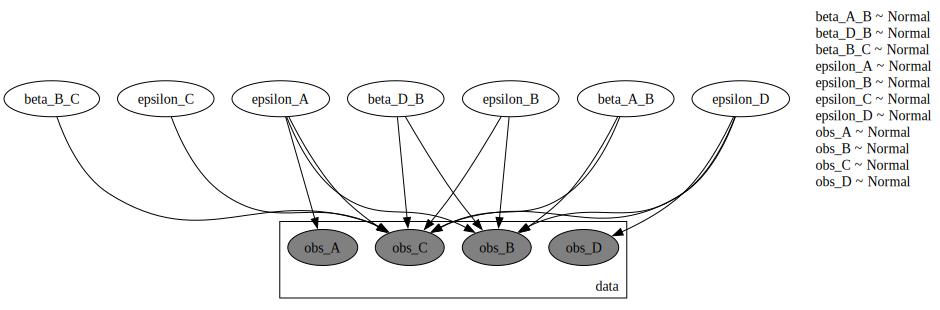

In [9]:
pyro.render_model(gene_network_model, model_args=(A,  B, C, D, num_samples), render_distributions=True)

Sample: 100%|██████████| 1200/1200 [00:52, 22.67it/s, step size=1.47e-01, acc. prob=0.841]


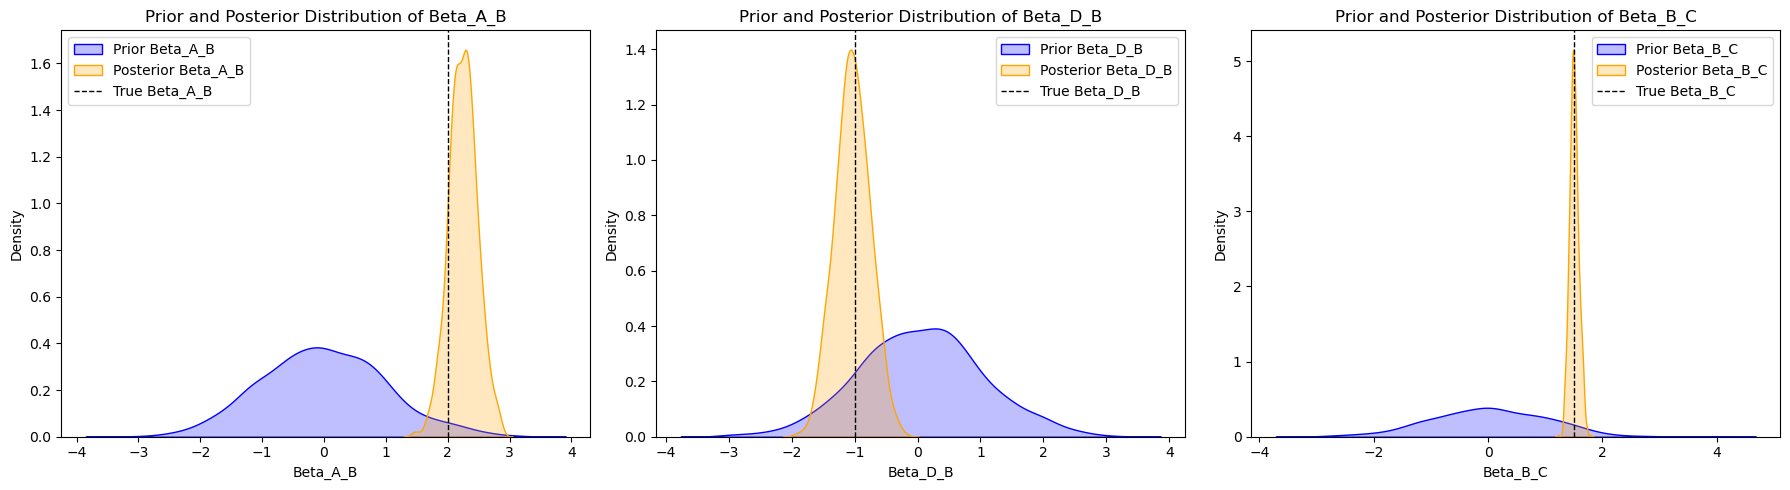

In [10]:
import pyro.infer.mcmc as mcmc
import pyro.infer.mcmc.api as mcmc_api

pyro.set_rng_seed(42)

# Perform MCMC inference
pyro.clear_param_store()
kernel = mcmc_api.NUTS(lambda A,  B, C, D: gene_network_model(A,  B, C, D, num_samples), adapt_step_size=True)
mcmc_run = mcmc_api.MCMC(kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmc_run.run(A, B, C, D)

# Extract samples
mcmc_samples = mcmc_run.get_samples()

# Prior samples for comparison
prior_sample_size = 1000
prior_beta_A_B = dist.Normal(0, 1).sample([prior_sample_size]).detach().numpy()
prior_beta_D_B = dist.Normal(0, 1).sample([prior_sample_size]).detach().numpy()
prior_beta_B_C = dist.Normal(0, 1).sample([prior_sample_size]).detach().numpy()

# Posterior samples
posterior_beta_A_B = mcmc_samples['beta_A_B'].detach().numpy()
posterior_beta_D_B = mcmc_samples['beta_D_B'].detach().numpy()
posterior_beta_B_C = mcmc_samples['beta_B_C'].detach().numpy()

# Plot KDEs
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.kdeplot(prior_beta_A_B, fill=True, color='blue', label='Prior Beta_A_B', ax=axs[0])
sns.kdeplot(posterior_beta_A_B, fill=True, color='orange', label='Posterior Beta_A_B', ax=axs[0])
axs[0].axvline(true_beta_A_B, color='black', linestyle='dashed', linewidth=1, label='True Beta_A_B')
axs[0].set_title('Prior and Posterior Distribution of Beta_A_B')
axs[0].set_xlabel('Beta_A_B')
axs[0].set_ylabel('Density')
axs[0].legend()

sns.kdeplot(prior_beta_D_B, fill=True, color='blue', label='Prior Beta_D_B', ax=axs[1])
sns.kdeplot(posterior_beta_D_B, fill=True, color='orange', label='Posterior Beta_D_B', ax=axs[1])
axs[1].axvline(true_beta_D_B, color='black', linestyle='dashed', linewidth=1, label='True Beta_D_B')
axs[1].set_title('Prior and Posterior Distribution of Beta_D_B')
axs[1].set_xlabel('Beta_D_B')
axs[1].set_ylabel('Density')
axs[1].legend()

sns.kdeplot(prior_beta_B_C, fill=True, color='blue', label='Prior Beta_B_C', ax=axs[2])
sns.kdeplot(posterior_beta_B_C, fill=True, color='orange', label='Posterior Beta_B_C', ax=axs[2])
axs[2].axvline(true_beta_B_C, color='black', linestyle='dashed', linewidth=1, label='True Beta_B_C')
axs[2].set_title('Prior and Posterior Distribution of Beta_B_C')
axs[2].set_xlabel('Beta_B_C')
axs[2].set_ylabel('Density')
axs[2].legend()

plt.tight_layout()
plt.show()


## SVI 

In [11]:
# Define the guide
guide = AutoNormal(gene_network_model)

# Set up the optimizer
optimizer = pyro.optim.Adam({"lr": 0.01})

# Set up the SVI object
svi = SVI(gene_network_model, guide, optimizer, loss=Trace_ELBO())

# Number of training steps
num_steps = 10000

# Run SVI
pyro.clear_param_store()
for step in range(num_steps):
    svi.step(A,  B, C, D, num_samples)
    if step % 500 == 0:
        elbo = svi.evaluate_loss(A, B, C,  D, num_samples)
        print(f'Step {step} - ELBO: {elbo}')


Step 0 - ELBO: 2360.133056640625
Step 500 - ELBO: 792.2889404296875
Step 1000 - ELBO: 750.77734375
Step 1500 - ELBO: 766.4236145019531
Step 2000 - ELBO: 781.1926574707031
Step 2500 - ELBO: 764.4713134765625
Step 3000 - ELBO: 757.5193176269531
Step 3500 - ELBO: 800.9688110351562
Step 4000 - ELBO: 796.0439758300781
Step 4500 - ELBO: 767.3738098144531
Step 5000 - ELBO: 748.7542724609375
Step 5500 - ELBO: 783.4791259765625
Step 6000 - ELBO: 765.2201232910156
Step 6500 - ELBO: 793.1871337890625
Step 7000 - ELBO: 783.4243469238281
Step 7500 - ELBO: 783.1581115722656
Step 8000 - ELBO: 777.117431640625
Step 8500 - ELBO: 764.3994140625
Step 9000 - ELBO: 770.0753784179688
Step 9500 - ELBO: 770.3861999511719


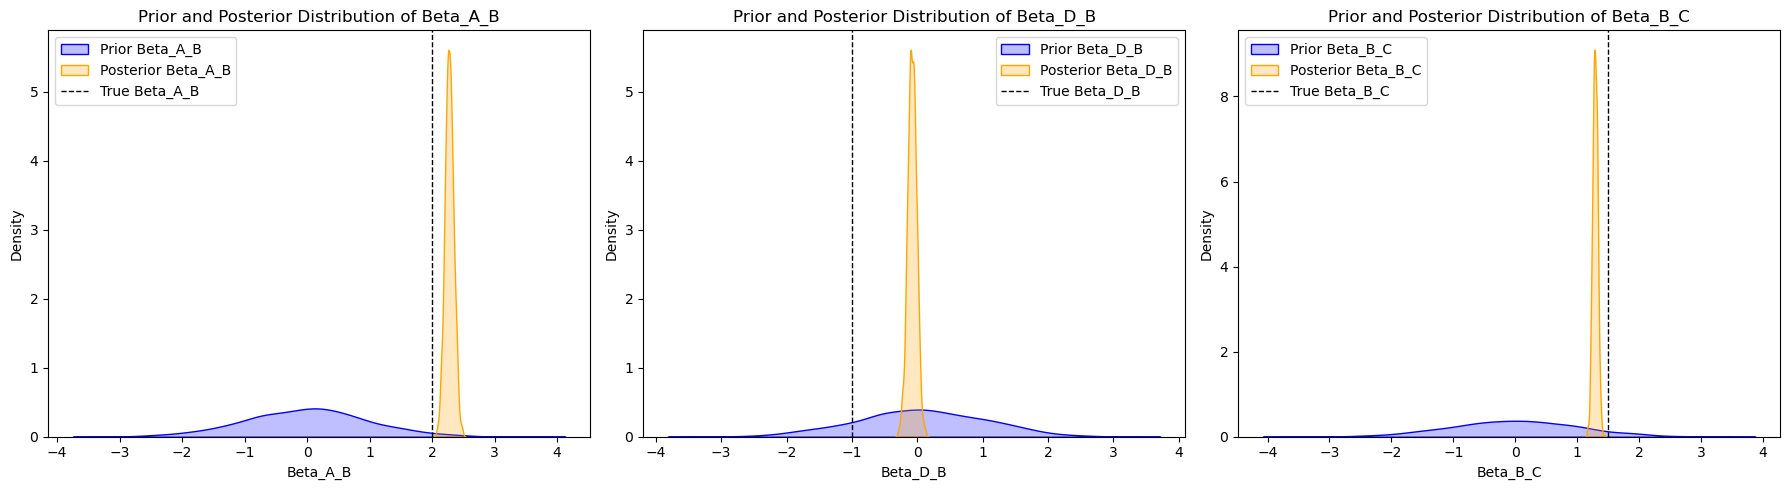

In [12]:
from pyro.infer import SVI, Trace_ELBO, Predictive

# Use Predictive to get posterior samples
predictive = Predictive(guide, num_samples=1000)
posterior_samples = predictive(A,  B, C, D, num_samples)
posterior_beta_A_B = posterior_samples['beta_A_B'].detach().numpy()
posterior_beta_D_B = posterior_samples['beta_D_B'].detach().numpy()
posterior_beta_B_C = posterior_samples['beta_B_C'].detach().numpy()

# Prior samples for comparison
prior_sample_size = 1000
prior_beta_A_B = dist.Normal(0, 1).sample([prior_sample_size]).detach().numpy()
prior_beta_D_B = dist.Normal(0, 1).sample([prior_sample_size]).detach().numpy()
prior_beta_B_C = dist.Normal(0, 1).sample([prior_sample_size]).detach().numpy()

# Plot KDEs
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.kdeplot(prior_beta_A_B, fill=True, color='blue', label='Prior Beta_A_B', ax=axs[0])
sns.kdeplot(posterior_beta_A_B, fill=True, color='orange', label='Posterior Beta_A_B', ax=axs[0])
axs[0].axvline(true_beta_A_B, color='black', linestyle='dashed', linewidth=1, label='True Beta_A_B')
axs[0].set_title('Prior and Posterior Distribution of Beta_A_B')
axs[0].set_xlabel('Beta_A_B')
axs[0].set_ylabel('Density')
axs[0].legend()

sns.kdeplot(prior_beta_D_B, fill=True, color='blue', label='Prior Beta_D_B', ax=axs[1])
sns.kdeplot(posterior_beta_D_B, fill=True, color='orange', label='Posterior Beta_D_B', ax=axs[1])
axs[1].axvline(true_beta_D_B, color='black', linestyle='dashed', linewidth=1, label='True Beta_D_B')
axs[1].set_title('Prior and Posterior Distribution of Beta_D_B')
axs[1].set_xlabel('Beta_D_B')
axs[1].set_ylabel('Density')
axs[1].legend()

sns.kdeplot(prior_beta_B_C, fill=True, color='blue', label='Prior Beta_B_C', ax=axs[2])
sns.kdeplot(posterior_beta_B_C, fill=True, color='orange', label='Posterior Beta_B_C', ax=axs[2])
axs[2].axvline(true_beta_B_C, color='black', linestyle='dashed', linewidth=1, label='True Beta_B_C')
axs[2].set_title('Prior and Posterior Distribution of Beta_B_C')
axs[2].set_xlabel('Beta_B_C')
axs[2].set_ylabel('Density')
axs[2].legend()

plt.tight_layout()
plt.show()


## SVI with multinormal

SVI Training Progress: 100%|██████████| 2000/2000 [00:07<00:00, 268.77it/s, ELBO=830]    


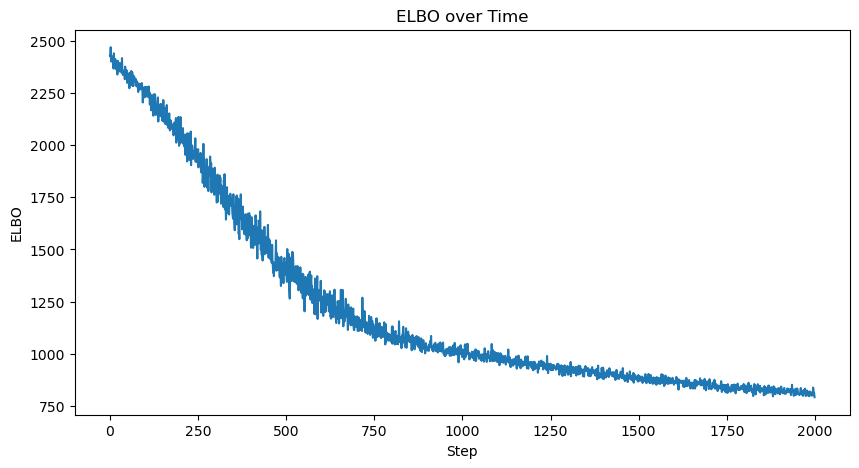

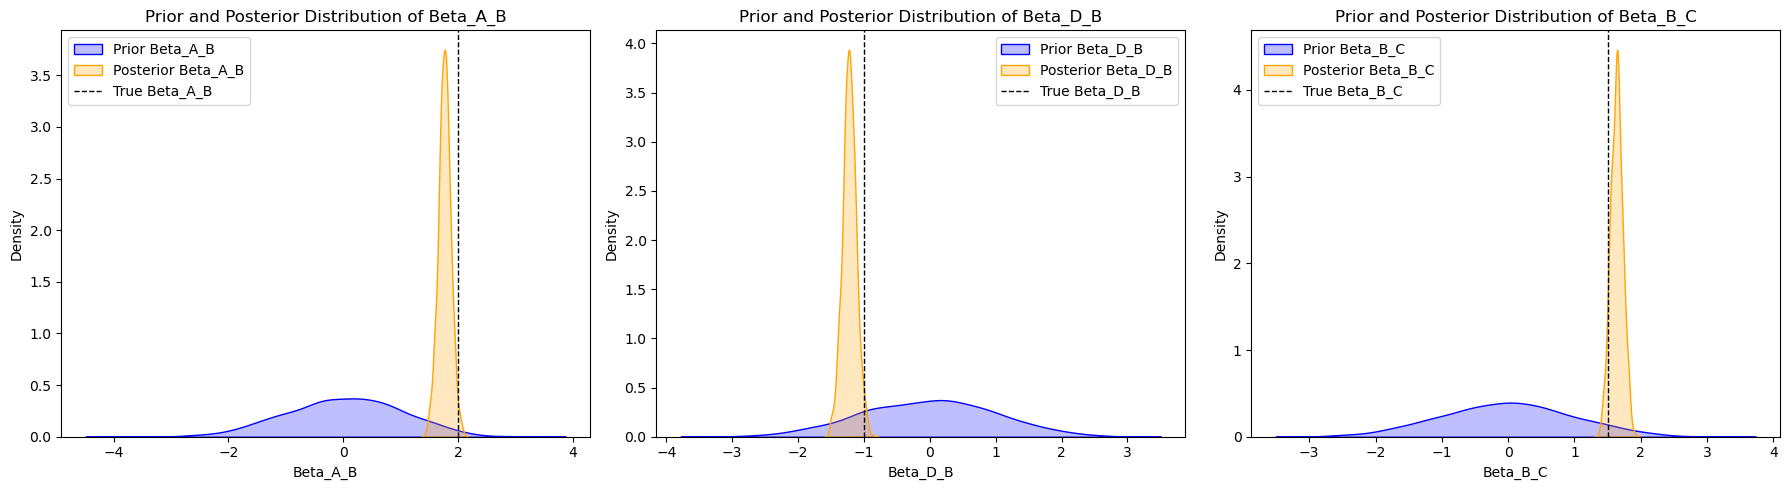

In [13]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal, AutoNormalizingFlow, AutoLowRankMultivariateNormal
from pyro.distributions.transforms import AffineAutoregressive
import pyro.optim  # Ensure that Pyro's optim module is imported
from pyro.optim import Adam, PyroLRScheduler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

pyro.set_rng_seed(40)

# Define the guide
guide = AutoMultivariateNormal(gene_network_model)
#guide = AutoNormal(gene_network_model)


# # Set up the optimizer
# adam_params = {"lr": 0.001}
# scheduler_params = {
#     "optimizer": torch.optim.Adam,
#     "optim_args": adam_params,
#     "step_size": 5000,  
#     "gamma": 0.3  
# }
# scheduler = pyro.optim.StepLR(scheduler_params)

scheduler =  Adam({"lr": 0.001})  # Use a constant learning rate

# Set up the SVI object
svi = SVI(gene_network_model, guide, scheduler, loss=Trace_ELBO())

# Number of training steps
num_steps = 2000

# Run SVI with progress bar
pyro.clear_param_store()
elbos = []
with tqdm(total=num_steps, desc="SVI Training Progress") as pbar:
    for step in range(num_steps):
        elbo = svi.step(A,B, C,  D, num_samples)
        elbos.append(elbo)
        if step % 100 == 0:
            pbar.set_postfix(ELBO=elbo)
        pbar.update(1)


# Plot ELBOs
plt.figure(figsize=(10, 5))
plt.plot(elbos)
plt.xlabel('Step')
plt.ylabel('ELBO')
plt.title('ELBO over Time')
plt.show()

# Posterior predictive checks
predictive = Predictive(guide, num_samples=1000)
posterior_samples = predictive(A=A, B=B, C=C, D=D, num_samples=num_samples)

posterior_beta_A_B = posterior_samples['beta_A_B'].detach().numpy().flatten()
posterior_beta_D_B = posterior_samples['beta_D_B'].detach().numpy().flatten()
posterior_beta_B_C = posterior_samples['beta_B_C'].detach().numpy().flatten()

# Prior samples for comparison
prior_sample_size = 1000
prior_beta_A_B = dist.Normal(0, 1).sample([prior_sample_size]).detach().numpy()
prior_beta_D_B = dist.Normal(0, 1).sample([prior_sample_size]).detach().numpy()
prior_beta_B_C = dist.Normal(0, 1).sample([prior_sample_size]).detach().numpy()

# Plot KDEs
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.kdeplot(prior_beta_A_B, fill=True, color='blue', label='Prior Beta_A_B', ax=axs[0])
sns.kdeplot(posterior_beta_A_B, fill=True, color='orange', label='Posterior Beta_A_B', ax=axs[0])
axs[0].axvline(true_beta_A_B, color='black', linestyle='dashed', linewidth=1, label='True Beta_A_B')
axs[0].set_title('Prior and Posterior Distribution of Beta_A_B')
axs[0].set_xlabel('Beta_A_B')
axs[0].set_ylabel('Density')
axs[0].legend()

sns.kdeplot(prior_beta_D_B, fill=True, color='blue', label='Prior Beta_D_B', ax=axs[1])
sns.kdeplot(posterior_beta_D_B, fill=True, color='orange', label='Posterior Beta_D_B', ax=axs[1])
axs[1].axvline(true_beta_D_B, color='black', linestyle='dashed', linewidth=1, label='True Beta_D_B')
axs[1].set_title('Prior and Posterior Distribution of Beta_D_B')
axs[1].set_xlabel('Beta_D_B')
axs[1].set_ylabel('Density')
axs[1].legend()

sns.kdeplot(prior_beta_B_C, fill=True, color='blue', label='Prior Beta_B_C', ax=axs[2])
sns.kdeplot(posterior_beta_B_C, fill=True, color='orange', label='Posterior Beta_B_C', ax=axs[2])
axs[2].axvline(true_beta_B_C, color='black', linestyle='dashed', linewidth=1, label='True Beta_B_C')
axs[2].set_title('Prior and Posterior Distribution of Beta_B_C')
axs[2].set_xlabel('Beta_B_C')
axs[2].set_ylabel('Density')
axs[2].legend()

plt.tight_layout()
plt.show()

# Adding technical noise to the model

# Making a pyro module

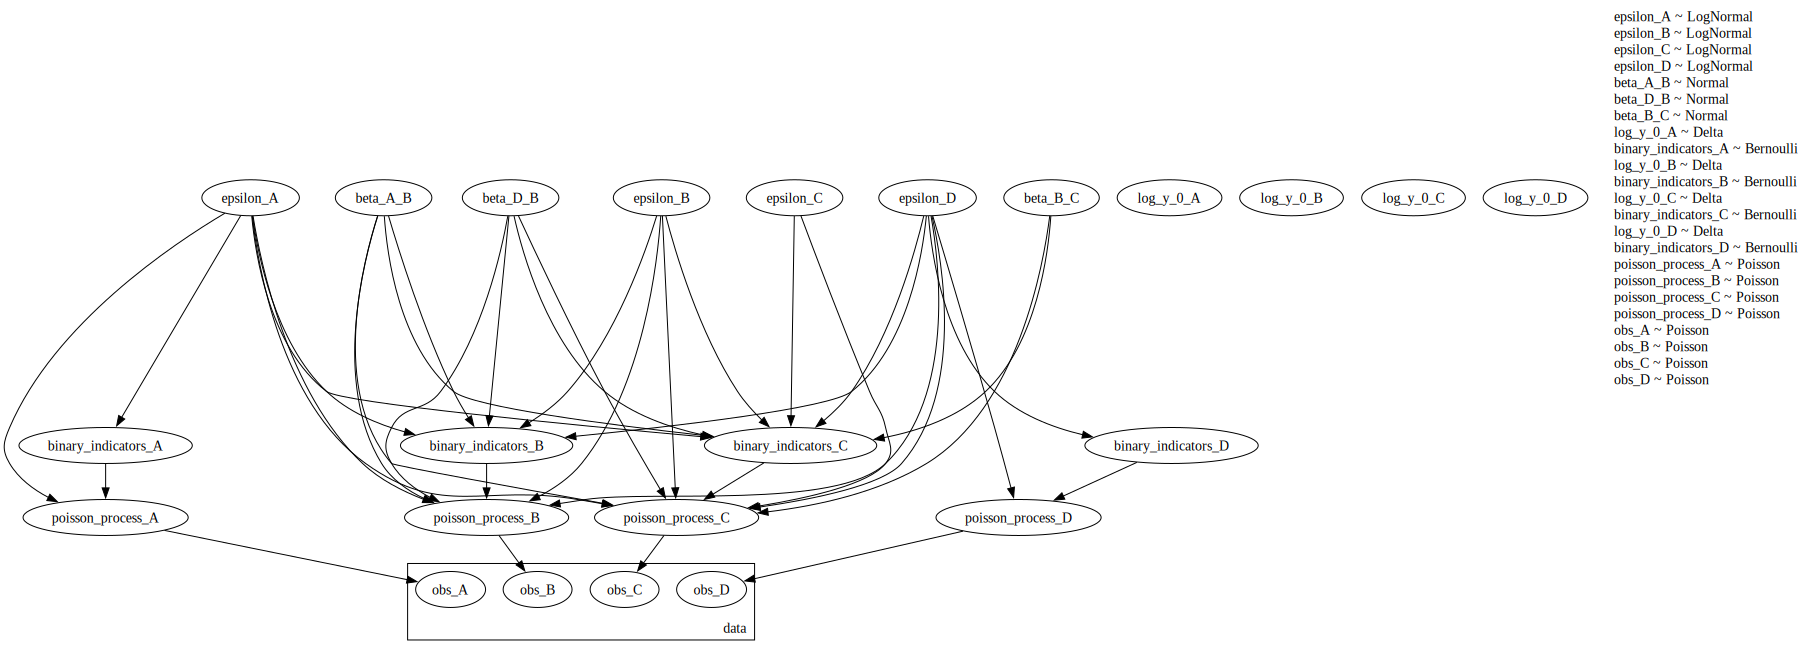

In [30]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule
import torch

class BiologicalProcess(PyroModule):
    def __init__(self, num_samples):
        super().__init__()
        self.num_samples = num_samples
        self.beta_A_B = pyro.param('beta_A_B', torch.tensor(2.0))
        self.beta_D_B = pyro.param('beta_D_B', torch.tensor(-1.0))
        self.beta_B_C = pyro.param('beta_B_C', torch.tensor(1.5))

    def forward(self):
        epsilon_A = pyro.sample('epsilon_A', dist.LogNormal(0, 1).expand([self.num_samples]).to_event(1))
        epsilon_B = pyro.sample('epsilon_B', dist.LogNormal(0, 1).expand([self.num_samples]).to_event(1))
        epsilon_C = pyro.sample('epsilon_C', dist.LogNormal(0, 1).expand([self.num_samples]).to_event(1))
        epsilon_D = pyro.sample('epsilon_D', dist.LogNormal(0, 1).expand([self.num_samples]).to_event(1))

        A = epsilon_A
        D = epsilon_D
        B = torch.exp(pyro.sample('beta_A_B', dist.Normal(self.beta_A_B, 1.0)) * torch.log(A) + 
                      pyro.sample('beta_D_B', dist.Normal(self.beta_D_B, 1.0)) * torch.log(D + 1) + 
                      torch.log(epsilon_B))
        C = torch.exp(pyro.sample('beta_B_C', dist.Normal(self.beta_B_C, 1.0)) * torch.log(B) + 
                      torch.log(epsilon_C))

        return A, B, C, D

class TechnicalNoiseProcess(PyroModule):
    def __init__(self, biological_model):
        super().__init__()
        self.biological_model = biological_model

    def apply_dropout(self, tensor, name, k=1.0, q=0.5):
        log_y = torch.log1p(tensor)  # use log1p to avoid log(0) issues
        log_y_0 = pyro.sample(f'log_y_0_{name}', dist.Delta(torch.tensor(torch.quantile(log_y, q).item())))  # Capture in graph
        pi = 1 / (1 + torch.exp(-k * (log_y - log_y_0)))
        pi = torch.clamp(pi, 0.0, 1.0)  # Ensure valid probabilities
        binary_indicators = pyro.sample(f'binary_indicators_{name}', dist.Bernoulli(pi))  # Capture in graph
        return binary_indicators * tensor

    def apply_poisson_process(self, tensor, name):
        return pyro.sample(f'poisson_process_{name}', dist.Poisson(tensor))  # Capture in graph

    def forward(self, A_obs=None, B_obs=None, C_obs=None, D_obs=None):
        # Generate biological signals
        A_bio, B_bio, C_bio, D_bio = self.biological_model()

        # Apply technical noise processes
        A_bio_dropped = self.apply_dropout(A_bio, 'A')
        B_bio_dropped = self.apply_dropout(B_bio, 'B')
        C_bio_dropped = self.apply_dropout(C_bio, 'C')
        D_bio_dropped = self.apply_dropout(D_bio, 'D')

        A_noisy = self.apply_poisson_process(A_bio_dropped, 'A')
        B_noisy = self.apply_poisson_process(B_bio_dropped, 'B')
        C_noisy = self.apply_poisson_process(C_bio_dropped, 'C')
        D_noisy = self.apply_poisson_process(D_bio_dropped, 'D')

        # Define likelihoods for observed data
        with pyro.plate('data', self.biological_model.num_samples):
            pyro.sample('obs_A', dist.Poisson(A_noisy), obs=A_obs)
            pyro.sample('obs_B', dist.Poisson(B_noisy), obs=B_obs)
            pyro.sample('obs_C', dist.Poisson(C_noisy), obs=C_obs)
            pyro.sample('obs_D', dist.Poisson(D_noisy), obs=D_obs)

# Example usage
num_samples = 100

# Instantiate the technical noise process model with the biological model
technical_noise_process = TechnicalNoiseProcess(BiologicalProcess(num_samples))

# # generate observational data from the model


# # Render the model with the generated observational samples
# pyro.render_model(technical_noise_process, model_args=(A_obs, B_obs, C_obs, D_obs), render_distributions=True)

# generate observational data from the model


# Render the model with the generated observational samples
pyro.render_model(technical_noise_process, render_distributions=True)
